In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier, MLPRegressor
import tensorflow as tf
from tensorflow.keras import layers, models

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [42]:
df=pd.read_csv("Building_Permits.csv",encoding = 'latin1' )
#df=pd.read_csv("Building_Permits.csv")
df.info()

/tmp/ipython-input-3338075672.py:1: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("Building_Permits.csv",encoding = 'latin1' )


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Permit Number                           198900 non-null  object 
 1   Permit Type                             198900 non-null  int64  
 2   Permit Type Definition                  198900 non-null  object 
 3   Permit Creation Date                    198900 non-null  object 
 4   Block                                   198900 non-null  object 
 5   Lot                                     198900 non-null  object 
 6   Street Number                           198900 non-null  int64  
 7   Street Number Suffix                    2216 non-null    object 
 8   Street Name                             198900 non-null  object 
 9   Street Suffix                           196132 non-null  object 
 10  Unit                                    2947

In [43]:
df.shape

(198900, 43)

In [44]:
print(df.isnull().sum())

Permit Number                                  0
Permit Type                                    0
Permit Type Definition                         0
Permit Creation Date                           0
Block                                          0
Lot                                            0
Street Number                                  0
Street Number Suffix                      196684
Street Name                                    0
Street Suffix                               2768
Unit                                      169421
Unit Suffix                               196939
Description                                  290
Current Status                                 0
Current Status Date                            0
Filed Date                                     0
Issued Date                                14940
Completed Date                            101709
First Construction Document Date           14946
Structural Notification                   191978
Number of Existing S

In [45]:
#drop columns which have nearly no values, are mostly NA
df = df.drop(columns=["Street Number Suffix","Unit Suffix","Unit","Structural Notification","Voluntary Soft-Story Retrofit","TIDF Compliance","Site Permit","Description"])

In [46]:
#column only has two values, Y or N
df["Fire Only Permit"]=df["Fire Only Permit"].fillna("N")

In [47]:
#drop rows with empty values since we have ample data
df = df.dropna()
df.shape

(86824, 35)

In [48]:
# 1. Split numeric & categorical
numeric_df = df.select_dtypes(include=['int64', 'float64'])
categorical_df = df.select_dtypes(include=['object', 'category'])

# Small / Large categorical
small_cat_cols = [c for c in categorical_df if categorical_df[c].nunique() <= 10]
large_cat_cols = [c for c in categorical_df if categorical_df[c].nunique() > 10]

# 2. OneHotEncode small categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
small_encoded = encoder.fit_transform(categorical_df[small_cat_cols])
small_encoded_df = pd.DataFrame(
    small_encoded,
    columns=encoder.get_feature_names_out(small_cat_cols)
)

# 3. Ordinal-encode large categorical columns
ord_enc = OrdinalEncoder()
large_encoded = ord_enc.fit_transform(categorical_df[large_cat_cols])
large_encoded_df = pd.DataFrame(
    large_encoded,
    columns=large_cat_cols
)

# 4. Combine
final_df = pd.concat(
    [numeric_df.reset_index(drop=True),
     small_encoded_df,
     large_encoded_df],
    axis=1
)

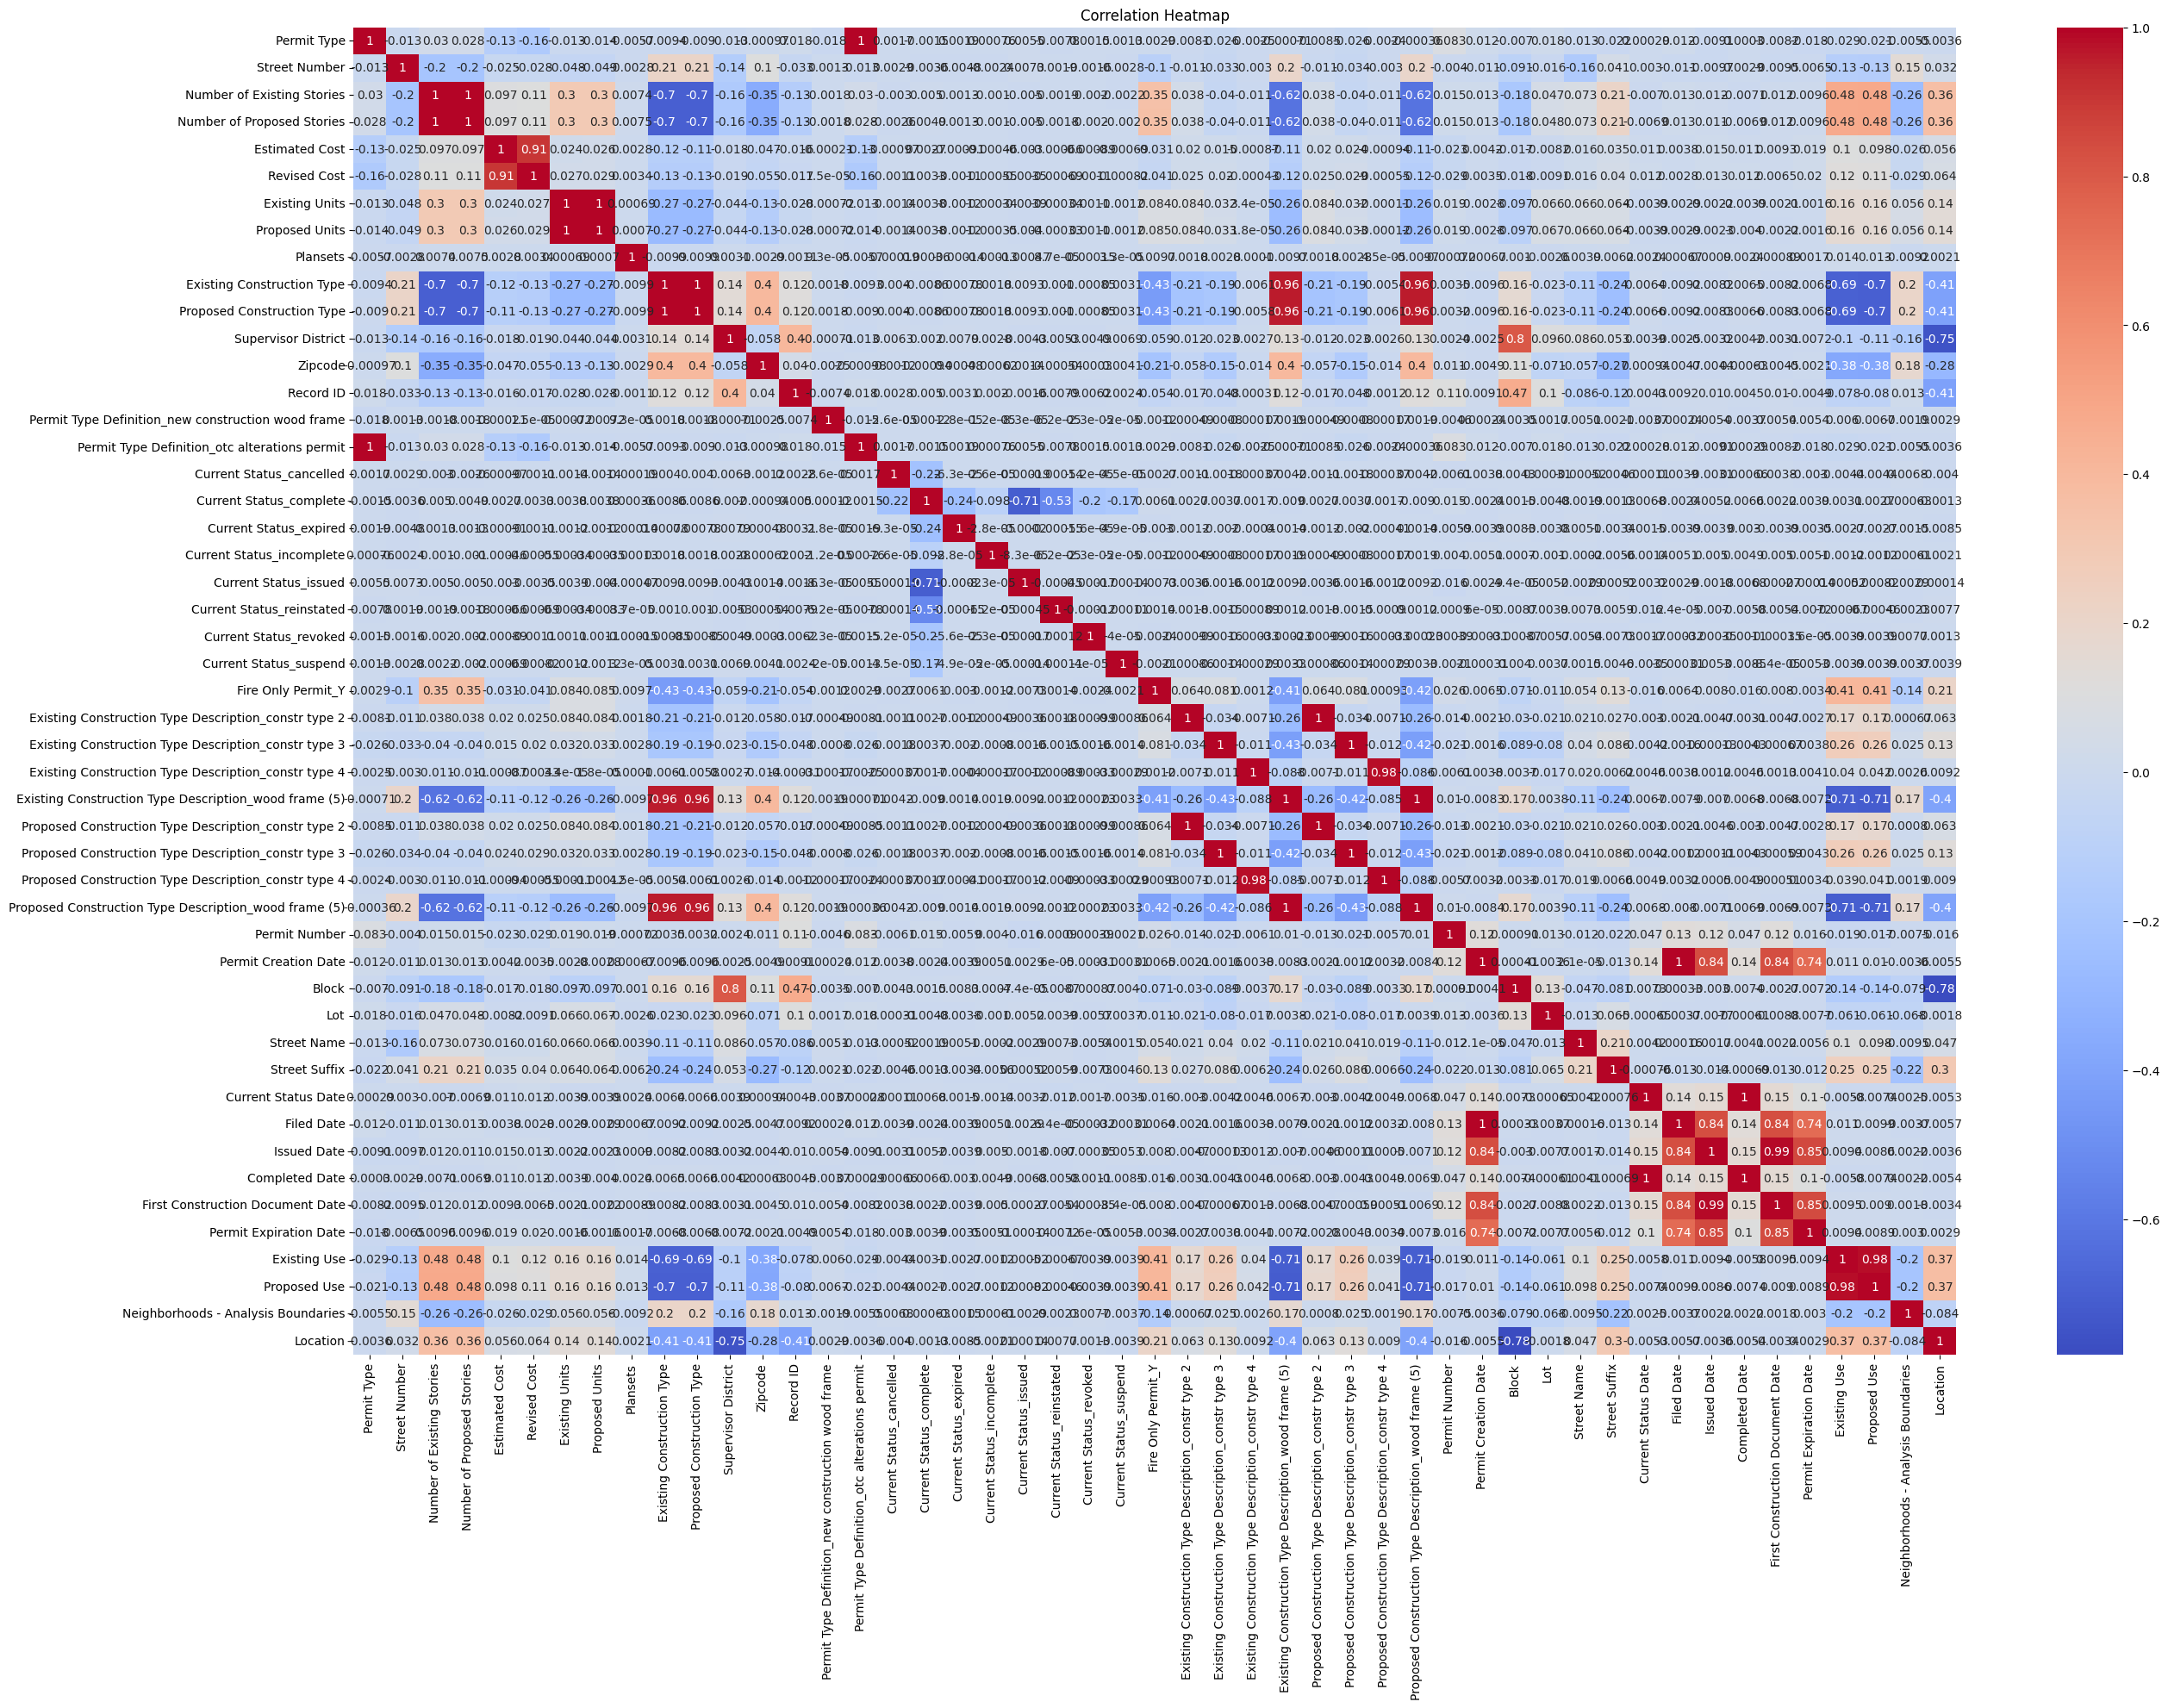

In [49]:
plt.figure(figsize=(30,20))
sns.heatmap(final_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

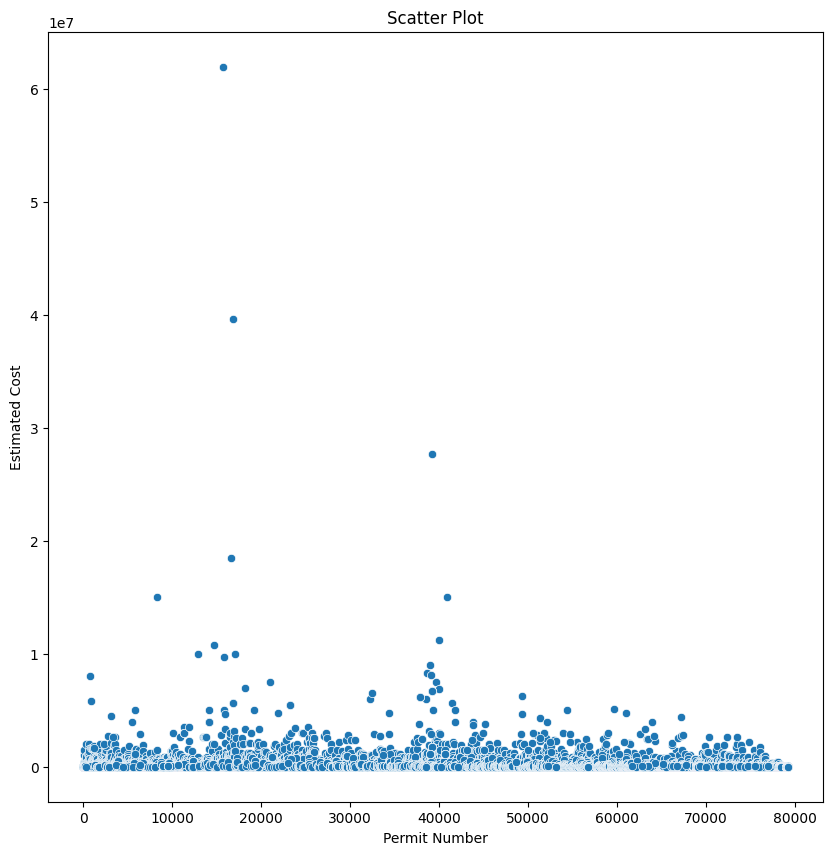

In [50]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='Permit Number' , y='Estimated Cost',data=final_df )
plt.title("Scatter Plot")
plt.show()

In [51]:
# CLASSIFICATION (Current Status)

current_status_cols = [col for col in final_df.columns if col.startswith("Current Status_")]
XC = final_df.drop(columns=current_status_cols)
#XC = final_df.drop(columns=["Current Status"])
YC = df["Current Status"]

XC_train, XC_test, YC_train, YC_test = train_test_split(
    XC, YC, test_size=0.2, random_state=42
)
scaler = StandardScaler()
XC_train_scaled = scaler.fit_transform(XC_train)
XC_test_scaled  = scaler.transform(XC_test)

pca1 = PCA(n_components=0.95)
XC_train_pca = pca1.fit_transform(XC_train_scaled)
XC_test_pca  = pca1.transform(XC_test_scaled)

In [52]:
# REGRESSION (Estimated Cost)
XR = final_df.drop(columns=["Estimated Cost"])
YR = df["Estimated Cost"]

XR_train, XR_test, YR_train, YR_test = train_test_split(
    XR, YR, test_size=0.2, random_state=42
)

scaler = StandardScaler()
XR_train_scaled = scaler.fit_transform(XR_train)
XR_test_scaled  = scaler.transform(XR_test)

pca2 = PCA(n_components=0.95)
XR_train_pca = pca2.fit_transform(XR_train_scaled)
XR_test_pca  = pca2.transform(XR_test_scaled)


In [53]:
# Linear Regression
reg_model = LinearRegression()
reg_model.fit(XR_train_pca, YR_train)
y_pred1 = reg_model.predict(XR_test_pca)
print(f"R2 Score: {r2_score(YR_test, y_pred1):.5f}")

R2 Score: 0.92667


In [54]:
#Linear Regression from scratch

# Predict function
def predict(X, theta):
    return np.dot(X, theta[1:]) + theta[0]

# Gradient descent
def gradient_descent_mse(X, Y, lr=0.0001, iterations=1000):
    m, n = X.shape
    theta = np.zeros(n + 1)  # first element is intercept

    for it in range(iterations):
        preds = predict(X, theta)
        error = preds - Y

        grad0 = (1/m) * np.sum(error)           # intercept
        grad_rest = (1/m) * np.dot(X.T, error)  # all feature weights

        theta[0] -= lr * grad0
        theta[1:] -= lr * grad_rest

    return theta
# Train model
theta = gradient_descent_mse(XR_train_pca, YR_train, lr=0.0001, iterations=1000)

# Predictions
ytr_pred = predict(XR_train_pca, theta)
yt_pred  = predict(XR_test_pca, theta)

# R^2 scores
r2_train = r2_score(YR_train, ytr_pred)
r2_test  = r2_score(YR_test, yt_pred)

print(f"Theta coefficients:{np.array2string(theta, precision=5)}")
print(f"R^2 on train:{r2_train:.5f}")
print(f"R^2 on test:{r2_test:.5f}")

Theta coefficients:[ 4.85373e+03 -9.15910e+03  8.07888e+02  7.19274e+02  2.13851e+03
 -1.02434e+04 -2.49739e+03 -5.64436e+03 -2.55171e+02 -9.46601e+01
 -2.80492e+03 -2.51824e+03 -2.05286e+03 -1.21910e+04 -9.44439e+03
 -2.22227e+02 -2.28984e+02  3.80294e+02  1.93684e+02 -1.37134e+01
  1.09504e+04  1.98017e+03  2.22514e+04  6.94392e+02 -3.89984e+03
  5.36905e+03  7.04578e+03  1.65048e+03]
R^2 on train:0.14603
R^2 on test:0.17373


In [55]:
# Logistic Regression
clf_model = LogisticRegression(max_iter=500)
clf_model.fit(XC_train_pca, YC_train)
y_pred2 = clf_model.predict(XC_test_pca)
print(f"Accuracy: {accuracy_score(YC_test, y_pred2):.5f}")

Accuracy: 0.99902


In [56]:
# Logistic Regression from scratch
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def gradientDescent_logistic(X, Y, lr=0.02, iterations=10000):
    m, n = X.shape
    theta = np.zeros(n + 1)
    cost_history = []

    for i in range(iterations):
        z = np.dot(X, theta[1:]) + theta[0]
        Y_pred = sigmoid(z)

        epsilon = 1e-15
        cost = -np.mean(Y * np.log(Y_pred + epsilon) + (1 - Y) * np.log(1 - Y_pred + epsilon))
        cost_history.append(cost)

        error = Y_pred - Y
        grad0 = np.mean(error)
        grad_rest = np.dot(X.T, error) / m

        theta[0] -= lr * grad0
        theta[1:] -= lr * grad_rest

        if i % 2000 == 0:
            print(f"Iteration {i}: Cost = {cost:.6f}")
    return theta, cost_history

def predict_logistic(X, theta):
    z = np.dot(X, theta[1:]) + theta[0]
    Y_prob = sigmoid(z)
    predictions = []
    for p in Y_prob:
        if p >= 0.5:
            predictions.append(1)  # class 1
        else:
            predictions.append(0)  # class 0

    return np.array(predictions), Y_prob


In [57]:
YC_binary = df["Current Status"].map({"approved": 1, "complete": 0,"issued": 0, "reinstated": 0, "expired": 0, "revoked": 0, "cancelled": 0, "suspend": 0, "incomplete": 0
})

XC_trainLR, XC_testLR, YC_trainLR, YC_testLR = train_test_split(
    XC, YC_binary, test_size=0.2, random_state=42
)
scaler = StandardScaler()
XC_train_scaled = scaler.fit_transform(XC_train)
XC_test_scaled  = scaler.transform(XC_test)

pca3 = PCA()
XC_train_pca_LR = pca3.fit_transform(XC_train_scaled)
XC_test_pca_LR  = pca3.transform(XC_test_scaled)

In [58]:
# Training
theta, cost_history = gradientDescent_logistic(XC_train_pca_LR, YC_trainLR, lr=0.02, iterations=10000)

# Predictions
Y_pred_train, Y_prob_train = predict_logistic(XC_train_pca_LR, theta)
Y_pred_test, Y_prob_test = predict_logistic(XC_test_pca_LR, theta)

Accuracy_train= accuracy_score (YC_trainLR,Y_pred_train)
print(f"\nAccuracy For Training Data :{Accuracy_train:.5f}")
Accuracy_test= accuracy_score (YC_testLR,Y_pred_test)
print(f"Accuracy For Testing Data : {Accuracy_test:.5f}")

Iteration 0: Cost = 0.693147
Iteration 2000: Cost = 0.026620
Iteration 4000: Cost = 0.013233
Iteration 6000: Cost = 0.008865
Iteration 8000: Cost = 0.006708

Accuracy For Training Data :0.99994
Accuracy For Testing Data : 1.00000


In [59]:
#Ridge Regularization
def Rmodel (alpha):
  Rmodel=Ridge(alpha)
  Rmodel.fit(XR_train_pca,YR_train)
  y_pred3 = Rmodel.predict(XR_test_pca)
  return y_pred3, r2_score(YR_test,y_pred3), mean_squared_error(YR_test,y_pred3),Rmodel.coef_,Rmodel.intercept_

y_predR,r2R,mseR,coefR,interceptR = Rmodel(alpha=0.01)
print("----------Ridge with alpha = 0.01----------")
print (f"R2 Score: {r2R:.5f}")
print (f"MSE: {mseR:.5f}")
print(f"Intercept: {interceptR:.5f}")
print("\nCoefficients:", coefR)

----------Ridge with alpha = 0.01----------
R2 Score: 0.92667
MSE: 3483063612.57983
Intercept: 51002.16781

Coefficients: [-1.70407676e+04  2.22964249e+03  3.08460868e+03  1.04718756e+04
 -5.47320167e+04 -1.37884753e+04 -3.13516539e+04 -1.42009374e+03
 -5.41629534e+02 -1.67753115e+04 -2.14145992e+04 -1.95572813e+04
 -1.25754888e+05 -9.85945630e+04 -2.33358492e+03 -2.40544230e+03
  3.99623178e+03  2.03641691e+03 -1.44192856e+02  1.15484435e+05
  2.13786361e+04  2.42567475e+05  8.18582918e+03 -5.13462424e+04
  7.40791513e+04  1.08204248e+05  2.72766602e+04]


In [60]:
#Lasso Regularization
def Lmodel (alpha):
  Lmodel=Lasso(alpha)
  Lmodel.fit(XR_train_pca,YR_train)
  y_pred4 = Lmodel.predict(XR_test_pca)
  return y_pred4, r2_score(YR_test,y_pred4), mean_squared_error(YR_test,y_pred4),Lmodel.coef_,Lmodel.intercept_

y_predL,r2L,mseL,coefL,interceptL = Lmodel(alpha=0.01)
print("----------Lasso with alpha = 0.01----------")
print (f"R2 Score:{r2L:.5f}")
print (f"MSE:{mseL:.5f}")
print(f"Intercept:{interceptL:.5f}")
print("\nCoefficients:", coefL)

----------Lasso with alpha = 0.01----------
R2 Score:0.92667
MSE:3483063999.85959
Intercept:51002.16781

Coefficients: [-1.70407666e+04  2.22964034e+03  3.08460509e+03  1.04718719e+04
 -5.47320157e+04 -1.37884713e+04 -3.13516511e+04 -1.42008879e+03
 -5.41624368e+02 -1.67753074e+04 -2.14145937e+04 -1.95572748e+04
 -1.25754896e+05 -9.85945672e+04 -2.33357527e+03 -2.40543264e+03
  3.99622235e+03  2.03640720e+03 -1.44182870e+02  1.15484442e+05
  2.13786289e+04  2.42567501e+05  8.18581923e+03 -5.13462391e+04
  7.40791522e+04  1.08204256e+05  2.72766504e+04]


In [61]:
#SVM CLassifier
SVMmodel = SVC(kernel = "linear")
SVMmodel.fit(XC_train_pca,YC_train)
y_pred5 = SVMmodel.predict(XC_test_pca)

accuracy = accuracy_score(YC_test,y_pred5)
print(f"Accuracy: {accuracy:.5f}")
precision = precision_score(YC_test,y_pred5,average='weighted')
print(f"Precision {precision:.5f}")
f1 = f1_score(YC_test,y_pred5,average='weighted')
print(f"F1: {f1:.5f}")
recall = recall_score(YC_test,y_pred5, average='weighted')
print(f"Recall: {recall:.5f}")

Accuracy: 0.99902
Precision 0.99804
F1: 0.99853
Recall: 0.99902


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [62]:
#Navie Bayes
modelNB = GaussianNB()
modelNB.fit(XC_train_pca,YC_train)
y_pred6 = modelNB.predict(XC_test_pca)
AccuracyNB= accuracy_score (YC_test,y_pred6)
print(f"Accuracy: {AccuracyNB:.5f}")
precisionNB  = precision_score(YC_test,y_pred6,average='weighted')
print(f"Precision: {precisionNB:.5f}")
f1NB = f1_score(YC_test,y_pred6,average='weighted')
print(f"F1: {f1NB:.5f}")
recallNB = recall_score(YC_test,y_pred6, average='weighted')
print(f"Recall: {recallNB:.5f}")

Accuracy: 0.71080
Precision: 0.99813
F1: 0.83012
Recall: 0.71080


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
#KNN
modelKNN = KNeighborsClassifier(n_neighbors=3)
modelKNN.fit(XC_train_pca,YC_train)
y_pred7 = modelKNN.predict(XC_test_pca)

AccuracyKNN= accuracy_score (YC_test,y_pred7)
print(f"Accuracy: {AccuracyKNN:.5f}")
precisionKNN = precision_score(YC_test,y_pred7,average='weighted')
print(f"Precision: {precisionKNN:.5f}")
f1KNN = f1_score(YC_test,y_pred7,average='weighted')
print(f"F1: {f1KNN:.5f}")
recallKNN = recall_score(YC_test,y_pred7, average='weighted')
print(f"Recall: {recallKNN:.5f}")

Accuracy: 0.99885
Precision: 0.99827
F1: 0.99853
Recall: 0.99885


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [64]:
#Decision Trees
modelDT =DecisionTreeClassifier(random_state=0)
modelDT.fit(XC_train_pca,YC_train)
y_pred8 = modelDT.predict(XC_test_pca)
AccuracyDT= accuracy_score (YC_test,y_pred8)
print(f"Accuracy: {AccuracyDT:.5f}")
precisionDT = precision_score(YC_test,y_pred8,average='weighted')
print(f"Precision: {precisionDT:.5f}")
f1DT = f1_score(YC_test,y_pred8,average='weighted')
print(f"F1: {f1DT:.5f}")
recallDT  = recall_score(YC_test,y_pred8, average='weighted')
print(f"Recall: {recallDT:.5f}")

Accuracy: 0.99787
Precision: 0.99816
F1: 0.99801
Recall: 0.99787


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
#Random Forests
modelRF = RandomForestClassifier(n_estimators = 10, random_state=0)
modelRF.fit(XC_train_pca,YC_train)
y_pred9 = modelRF.predict(XC_test_pca)
AccuracyRT= accuracy_score (YC_test,y_pred9)
print(f"Accuracy: {AccuracyRT:.5f}")
precisionRF = precision_score(YC_test,y_pred9,average='weighted')
print(f"Precision: {precisionRF:.5f}")
f1RF = f1_score(YC_test,y_pred9,average='weighted')
print(f"F1: {f1RF:.5f}")
recallRF = recall_score(YC_test,y_pred9, average='weighted')
print(f"Recall: {recallRF:.5f}")

Accuracy: 0.99908
Precision: 0.99879
F1: 0.99867
Recall: 0.99908


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
# Single-layer perceptron
perceptron_model= Perceptron(random_state=42)
perceptron_model.fit(XC_train, YC_train)

yt_pred_PERCEPTRON = perceptron_model.predict(XC_test)
ytr_pred_PERCEPTRON = perceptron_model.predict(XC_train)
TestAcuuracy_P = accuracy_score(YC_test, yt_pred_PERCEPTRON)
TrainAcuuracy_P = accuracy_score(YC_train, ytr_pred_PERCEPTRON)

TestPrecision_P = precision_score(YC_test, yt_pred_PERCEPTRON, average="weighted")
TrainPrecision_P = precision_score(YC_train, ytr_pred_PERCEPTRON, average = "weighted")
TestRecall_P = recall_score(YC_test, yt_pred_PERCEPTRON , average = "weighted")
TrainRecall_P = recall_score(YC_train, ytr_pred_PERCEPTRON, average = "weighted")
TestF1_P = f1_score(YC_test, yt_pred_PERCEPTRON, average = "weighted")
TrainF1_P = f1_score(YC_train, ytr_pred_PERCEPTRON, average = "weighted")

print(f"----------Test Evaluation Metrics:----------")
print(f"Accuracy: {TestAcuuracy_P:.5f}")
print(f"Precision: {TestPrecision_P:.5f}")
print(f"Recall: {TestRecall_P:.5f}")
print(f"F1 Score: {TestF1_P:.5f}")

print(f"\n----------Train Evaluation Metrics:----------")
print(f"Accuracy: {TrainAcuuracy_P:.5f}")
print(f"Precision: {TrainPrecision_P:.5f}")
print(f"Recall: {TrainRecall_P:.5f}")
print(f"F1 score: {TrainF1_P:.5f}")


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


----------Test Evaluation Metrics:----------
Accuracy: 0.99902
Precision: 0.99804
Recall: 0.99902
F1 Score: 0.99853

----------Train Evaluation Metrics:----------
Accuracy: 0.99875
Precision: 0.99750
Recall: 0.99875
F1 score: 0.99812


In [67]:
print("----------Train class counts:----------\n", YC_train.value_counts())
print("\n----------Test class counts:----------\n", YC_test.value_counts())

----------Train class counts:----------
 Current Status
complete      69372
issued           40
reinstated       27
expired           5
cancelled         5
approved          4
suspend           3
revoked           2
incomplete        1
Name: count, dtype: int64

----------Test class counts:----------
 Current Status
complete      17348
issued           12
reinstated        2
revoked           2
expired           1
Name: count, dtype: int64


In [68]:
# Multi-Layer Perceptron ( Regression )
modelMLPR = MLPRegressor(hidden_layer_sizes = (5,5),activation = 'relu' ,solver='adam',max_iter = 7000, random_state=42)
modelMLPR.fit(XR_train_pca,YR_train)
Y_pred10 = modelMLPR.predict(XR_test_pca)

Reg_Score = r2_score(YR_test,Y_pred10)
print(f"Regression_score: {Reg_Score:.5f}")
mse = mean_squared_error(YR_test,Y_pred10)
print(f"MSE: {mse:.5f}")


Regression_score: 0.94000
MSE: 2849789318.28206


In [69]:
# Multi-Layer Perceptron ( Classification )
modelMLPC = MLPClassifier(hidden_layer_sizes = (5,5),activation = 'logistic' ,solver='lbfgs',max_iter = 7000, random_state=0)
modelMLPC.fit(XC_train_pca,YC_train)
Y_pred11 = modelMLPC.predict(XC_test_pca)

accuracy = accuracy_score(YC_test,Y_pred11)
print(f"Accuracy: {accuracy:.5f}")
precision = precision_score(YC_test,Y_pred11,average="weighted")
print(f"Precision: {precision:.5f}")
f1 = f1_score(YC_test,Y_pred11,average="weighted")
print(f"F1: {f1:.5f}")
recall = recall_score(YC_test,Y_pred11,average="weighted")
print(f"Recall: {recall:.5f}")

Accuracy: 0.99902
Precision: 0.99804
F1: 0.99853
Recall: 0.99902


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
#K-FOLD validation
# with Logistic Regression
k = 5
kf = KFold(n_splits=k, random_state=42, shuffle=True)
cv_scores = cross_val_score(LogisticRegression(), XC_train_pca, YC_train, cv=kf)

regression_model= LogisticRegression ()
regression_model.fit(XC_train_pca, YC_train)

yt_pred_K = regression_model.predict(XC_test_pca)
ytr_pred_K = regression_model.predict(XC_train_pca)
TestAcuuracy_K = accuracy_score(YC_test, yt_pred_K)
TrainAcuuracy_K = accuracy_score(YC_train, ytr_pred_K)

TestPrecision_K = precision_score(YC_test, yt_pred_K, average="weighted")
TrainPrecision_K = precision_score(YC_train, ytr_pred_K, average = "weighted")

TestRecall_K = recall_score(YC_test, yt_pred_K , average = "weighted")
TrainRecall_K = recall_score(YC_train, ytr_pred_K, average = "weighted")

TestF1_K = f1_score(YC_test, yt_pred_K, average = "weighted")
TrainF1_K = f1_score(YC_train, ytr_pred_K, average = "weighted")

print("----------For K = 5----------")
print("\n-----Test Evaluation Metrics:-----")
print(f"Accuracy: {TestAcuuracy_K:.5f}")
print(f"Precision: {TestPrecision_K:.5f}")
print(f"Recall: {TestRecall_K:.5f}")
print(f"F1 Score: {TestF1_K:.5f}")

print("\n-----Train Evaluation Metrics:-----")
print(f"Accuracy: {TrainAcuuracy_K:.5f}")
print(f"Precision: {TrainPrecision_K:.5f}")
print(f"Recall: {TrainRecall_K:.5f}")
print(f"F1 score: {TrainF1_K:.5f}")
print("")
print(f"CV Score: {np.mean(cv_scores):.5f}")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


----------For K = 5----------

-----Test Evaluation Metrics:-----
Accuracy: 0.99902
Precision: 0.99804
Recall: 0.99902
F1 Score: 0.99853

-----Train Evaluation Metrics:-----
Accuracy: 0.99875
Precision: 0.99750
Recall: 0.99875
F1 score: 0.99812

CV Score: 0.99875


In [71]:
# K fold Validation with Perceptron
k = 5
kf = KFold(n_splits=k, random_state=42, shuffle=True)
cv_scores_p = cross_val_score(Perceptron(), XC_train_pca, YC_train, cv=kf)

perceptron_model= Perceptron(random_state=42)
perceptron_model.fit(XC_train, YC_train)

yt_pred_PERCEPTRON = perceptron_model.predict(XC_test)
ytr_pred_PERCEPTRON = perceptron_model.predict(XC_train)
TestAcuuracy_P = accuracy_score(YC_test, yt_pred_PERCEPTRON)
TrainAcuuracy_P = accuracy_score(YC_train, ytr_pred_PERCEPTRON)

TestPrecision_P = precision_score(YC_test, yt_pred_PERCEPTRON, average="weighted")
TrainPrecision_P = precision_score(YC_train, ytr_pred_PERCEPTRON, average = "weighted")
TestRecall_P = recall_score(YC_test, yt_pred_PERCEPTRON , average = "weighted")
TrainRecall_P = recall_score(YC_train, ytr_pred_PERCEPTRON, average = "weighted")
TestF1_P = f1_score(YC_test, yt_pred_PERCEPTRON, average = "weighted")
TrainF1_P = f1_score(YC_train, ytr_pred_PERCEPTRON, average = "weighted")

print(f"----------Test Evaluation Metrics:----------")
print(f"Accuracy: {TestAcuuracy_P:.5f}")
print(f"Precision: {TestPrecision_P:.5f}")
print(f"Recall: {TestRecall_P:.5f}")
print(f"F1 Score: {TestF1_P:.5f}")

print(f"\n----------Train Evaluation Metrics:----------")
print(f"Accuracy: {TrainAcuuracy_P:.5f}")
print(f"Precision: {TrainPrecision_P:.5f}")
print(f"Recall: {TrainRecall_P:.5f}")
print(f"F1 score: {TrainF1_P:.5f}")
print("")
print(f"CV Score: {np.mean(cv_scores_p):.5f}")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


----------Test Evaluation Metrics:----------
Accuracy: 0.99902
Precision: 0.99804
Recall: 0.99902
F1 Score: 0.99853

----------Train Evaluation Metrics:----------
Accuracy: 0.99875
Precision: 0.99750
Recall: 0.99875
F1 score: 0.99812

CV Score: 0.99873


In [72]:
#K fold with Decision Trees

k = 5
kf = KFold(n_splits=k, random_state=42, shuffle=True)
cv_scores_dt = cross_val_score(DecisionTreeClassifier(), XC_train_pca, YC_train, cv=kf)

modelDT =DecisionTreeClassifier(random_state=0)
modelDT.fit(XC_train_pca,YC_train)
y_pred8_test = modelDT.predict(XC_test_pca)
y_pred8_train = modelDT.predict(XC_train_pca)

TestAcuuracy_DT = accuracy_score(YC_test, y_pred8_test)
TrainAcuuracy_DT = accuracy_score(YC_train,y_pred8_train )

TestPrecision_DT= precision_score(YC_test, y_pred8_test, average="weighted")
TrainPrecision_DT = precision_score(YC_train, y_pred8_train, average = "weighted")
TestRecall_DT = recall_score(YC_test, y_pred8_test , average = "weighted")
TrainRecall_DT = recall_score(YC_train, y_pred8_train, average = "weighted")
TestF1_DT = f1_score(YC_test, y_pred8_test, average = "weighted")
TrainF1_DT = f1_score(YC_train, y_pred8_train, average = "weighted")

print(f"----------Test Evaluation Metrics:----------")
print(f"Accuracy: {TestAcuuracy_DT:.5f}")
print(f"Precision: {TestPrecision_DT:.5f}")
print(f"Recall: {TestRecall_DT:.5f}")
print(f"F1 Score: {TestF1_DT:.5f}")

print(f"\n----------Train Evaluation Metrics:----------")
print(f"Accuracy: {TrainAcuuracy_DT:.5f}")
print(f"Precision: {TrainPrecision_DT:.5f}")
print(f"Recall: {TrainRecall_DT:.5f}")
print(f"F1 score: {TrainF1_DT:.5f}")
print("")
print(f"CV Score: {np.mean(cv_scores_dt):.5f}")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


----------Test Evaluation Metrics:----------
Accuracy: 0.99787
Precision: 0.99816
Recall: 0.99787
F1 Score: 0.99801

----------Train Evaluation Metrics:----------
Accuracy: 1.00000
Precision: 1.00000
Recall: 1.00000
F1 score: 1.00000

CV Score: 0.99760


In [77]:
#CNN
x_train_reshaped = XC_train_pca.reshape((XC_train_pca.shape[0], XC_train_pca.shape[1], 1, 1))
x_test_reshaped  = XC_test_pca.reshape((XC_test_pca.shape[0],XC_test_pca.shape[1], 1, 1))

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)
x_test_scaled  = scaler.transform(x_test_reshaped)

x_train = x_train_scaled.reshape((XC_train_pca.shape[0], XC_train_pca.shape[1], 1, 1))
x_test  = x_test_scaled.reshape((XC_test_pca.shape[0], XC_test_pca.shape[1], 1, 1))

# convert string labels → numbers
YC_train_codes = YC_train.astype('category').cat.codes
YC_test_codes  = YC_test.astype('category').cat.codes

num_classes = len(np.unique(YC_train_codes))

y_train = tf.keras.utils.to_categorical(YC_train_codes, num_classes)
y_test  = tf.keras.utils.to_categorical(YC_test_codes, num_classes)

print(f"Training data shape (after standardization): {x_train.shape}")
print(f"Training label shape: {y_train.shape}")

#building model

model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (2, 1), activation='relu', input_shape=(XC_train_pca.shape[1], 1, 1)),
    layers.MaxPooling2D((2, 1)),

    # Second Convolutional Block
    layers.Conv2D(64, (2, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")


ValueError: Found array with dim 4. StandardScaler expected <= 2.